## Project: Sales Data Analysis for Business Optimization
### Objective: Analyze sales data to uncover trends, predict sales, segment customers,
### optimize profitability, and provide actionable business recommendations.

#### Step 1: Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations

In [3]:
# Loading data
data = pd.read_csv('C:/Users/hh/Desktop/sales_data.csv', encoding='ISO-8859-1')
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'], errors='coerce')
data = data.dropna(subset=['SALES', 'ORDERDATE'])               # Drop critical missing values
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


#### Step 2: Data Cleaning

In [5]:
# Fill missing values
data['ADDRESSLINE2'] = data['ADDRESSLINE2'].fillna('Not Provided')
data['STATE'] = data['STATE'].fillna('Unknown')
data['POSTALCODE'] = data['POSTALCODE'].fillna('00000')

# Remove duplicates
data = data.drop_duplicates()

# Sort by date for time series
data = data.sort_values('ORDERDATE')

# Save cleaned data
data.to_csv('C:/Users/hh/Desktop/cleaned_sales_data.csv', index=False)

In [6]:
# importing ('cleaned_sales_data.csv')
data = pd.read_csv('C:/Users/hh/Desktop/cleaned_sales_data.csv', encoding='ISO-8859-1')
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10100,30,100.00,3,5151.00,2003-01-06,Shipped,1,1,2003,...,2304 Long Airport Avenue,Not Provided,Nashua,NH,62005,USA,NaN,Young,Valarie,Medium
1,10100,50,67.80,2,3390.00,2003-01-06,Shipped,1,1,2003,...,2304 Long Airport Avenue,Not Provided,Nashua,NH,62005,USA,NaN,Young,Valarie,Medium
2,10100,22,86.51,4,1903.22,2003-01-06,Shipped,1,1,2003,...,2304 Long Airport Avenue,Not Provided,Nashua,NH,62005,USA,NaN,Young,Valarie,Small
3,10100,49,34.47,1,1689.03,2003-01-06,Shipped,1,1,2003,...,2304 Long Airport Avenue,Not Provided,Nashua,NH,62005,USA,NaN,Young,Valarie,Small
4,10101,45,31.20,3,1404.00,2003-01-09,Shipped,1,1,2003,...,Lyonerstr. 34,Not Provided,Frankfurt,Unknown,60528,Germany,EMEA,Keitel,Roland,Small


#### Step 3: Exploratory Data Analysis (EDA) and Statistics

        ORDERNUMBER  QUANTITYORDERED    PRICEEACH  ORDERLINENUMBER  \
count   2823.000000      2823.000000  2823.000000      2823.000000   
mean   10258.725115        35.092809    83.658544         6.466171   
std       92.085478         9.741443    20.174277         4.225841   
min    10100.000000         6.000000    26.880000         1.000000   
25%    10180.000000        27.000000    68.860000         3.000000   
50%    10262.000000        35.000000    95.700000         6.000000   
75%    10333.500000        43.000000   100.000000         9.000000   
max    10425.000000        97.000000   100.000000        18.000000   

              SALES       QTR_ID     MONTH_ID     YEAR_ID         MSRP  
count   2823.000000  2823.000000  2823.000000  2823.00000  2823.000000  
mean    3553.889072     2.717676     7.092455  2003.81509   100.715551  
std     1841.865106     1.203878     3.656633     0.69967    40.187912  
min      482.130000     1.000000     1.000000  2003.00000    33.000000  
25% 

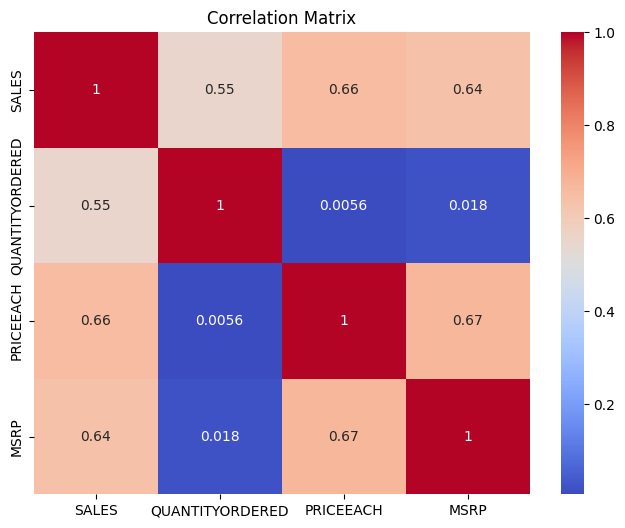

In [7]:
# Basic stats
print(data.describe())

# T-test: SALES by DEALSIZE
small_deals = data[data['DEALSIZE'] == 'Small']['SALES']
large_deals = data[data['DEALSIZE'] == 'Large']['SALES']
t_stat, p_value = stats.ttest_ind(small_deals.dropna(), large_deals.dropna())
print(f"T-test (Small vs Large Deals): t-stat={t_stat:.2f}, p-value={p_value:.4f}")

# Correlation
corr_matrix = data[['SALES', 'QUANTITYORDERED', 'PRICEEACH', 'MSRP']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_heatmap.png')
plt.show()

#### Step 4: Feature Engineering

In [9]:
# Convert ORDERDATE to datetime format
data['ORDERDATE'] = pd.to_datetime(data['ORDERDATE'], errors='coerce')

# Time-based features
data['ORDER_YEAR'] = data['ORDERDATE'].dt.year
data['ORDER_MONTH'] = data['ORDERDATE'].dt.month
data['ORDER_MONTH_YEAR'] = data['ORDERDATE'].dt.to_period('M')
data['SALES_LAG1'] = data['SALES'].shift(1)
data['SALES_ROLLING_7D'] = data['SALES'].rolling(window=7, min_periods=1).mean()

# Encode categorical variables
le = LabelEncoder()
data['PRODUCTLINE_ENCODED'] = le.fit_transform(data['PRODUCTLINE'])
data['DEALSIZE_ENCODED'] = le.fit_transform(data['DEALSIZE'])

# Proxy profit (PRICEEACH - MSRP as margin)
data['PROFIT'] = (data['PRICEEACH'] - data['MSRP']) * data['QUANTITYORDERED']

# Drop NaNs from new features
data = data.dropna()

# Save to CSV
data.to_csv('C:/Users/hh/Desktop/engineered_sales_data.csv', index=False)

In [10]:
# importing ('engineered_sales_data.csv')
data = pd.read_csv('C:/Users/hh/Desktop/engineered_sales_data.csv', encoding='ISO-8859-1')
data.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,CONTACTFIRSTNAME,DEALSIZE,ORDER_YEAR,ORDER_MONTH,ORDER_MONTH_YEAR,SALES_LAG1,SALES_ROLLING_7D,PRODUCTLINE_ENCODED,DEALSIZE_ENCODED,PROFIT
0,10101,45,31.20,3,1404.00,2003-01-09,Shipped,1,1,2003,...,Roland,Small,2003,1,2003-01,1689.03,2707.450000,6,2,-81.00
1,10101,46,53.76,2,2472.96,2003-01-09,Shipped,1,1,2003,...,Roland,Small,2003,1,2003-01,1404.00,2668.368333,6,2,448.96
2,10101,25,100.00,4,3782.00,2003-01-09,Shipped,1,1,2003,...,Roland,Medium,2003,1,2003-01,2472.96,2827.458571,6,1,-675.00
3,10101,26,100.00,1,3773.38,2003-01-09,Shipped,1,1,2003,...,Roland,Medium,2003,1,2003-01,3782.00,2630.655714,6,1,-1768.00
4,10103,42,100.00,6,4460.82,2003-01-29,Shipped,1,1,2003,...,Jonas,Medium,2003,1,2003-01,2055.74,3251.030000,0,1,-42.00


#### Step 5: Business-Focused Analyses
##### 1. Customer Segmentation

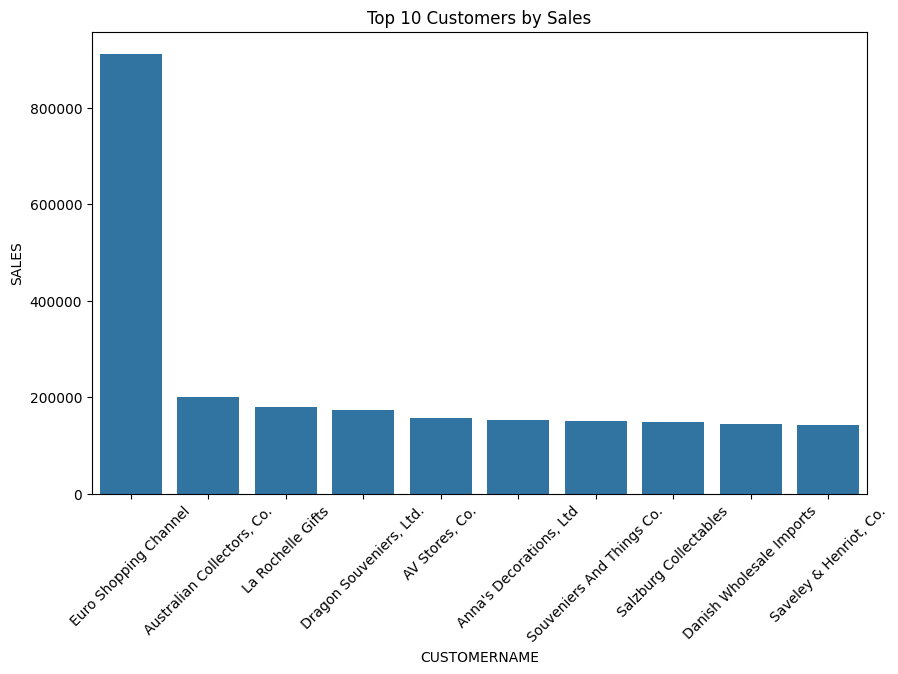

In [11]:
customer_summary = data.groupby('CUSTOMERNAME').agg({
    'SALES': 'sum',
    'ORDERNUMBER': 'nunique',
    'PROFIT': 'sum'
}).rename(columns={'ORDERNUMBER': 'ORDER_COUNT'})
customer_summary['SEGMENT'] = pd.qcut(customer_summary['SALES'], 3, labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(10, 6))
sns.barplot(x=customer_summary.nlargest(10, 'SALES').index, y=customer_summary.nlargest(10, 'SALES')['SALES'])
plt.xticks(rotation=45)
plt.title('Top 10 Customers by Sales')
plt.savefig('top_customers.png')
plt.show()

##### 2. Profitability Analysis

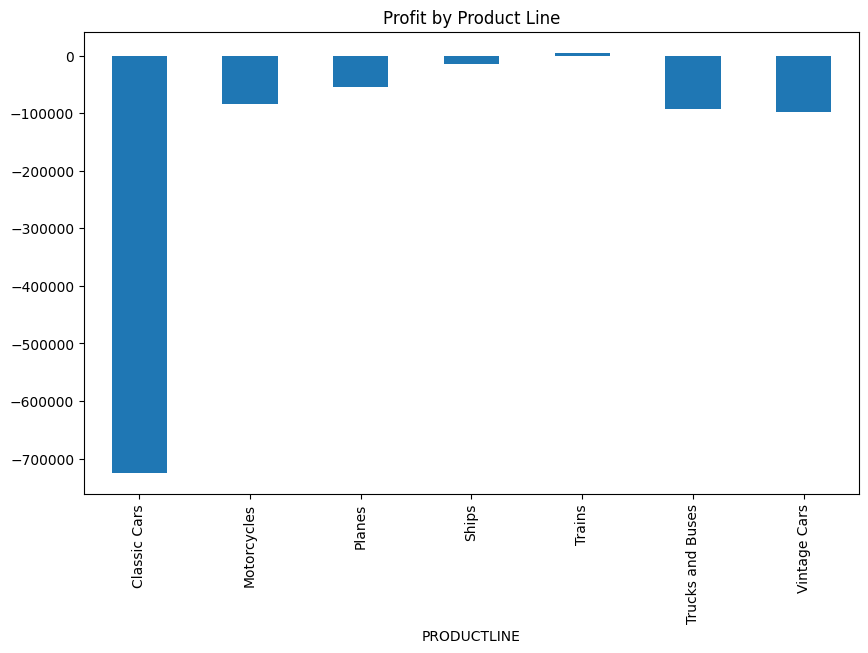

In [12]:
profit_by_product = data.groupby('PRODUCTLINE')['PROFIT'].sum()
plt.figure(figsize=(10, 6))
profit_by_product.plot(kind='bar', title='Profit by Product Line')
plt.savefig('profit_by_product.png')
plt.show()

##### 3. Inventory Management

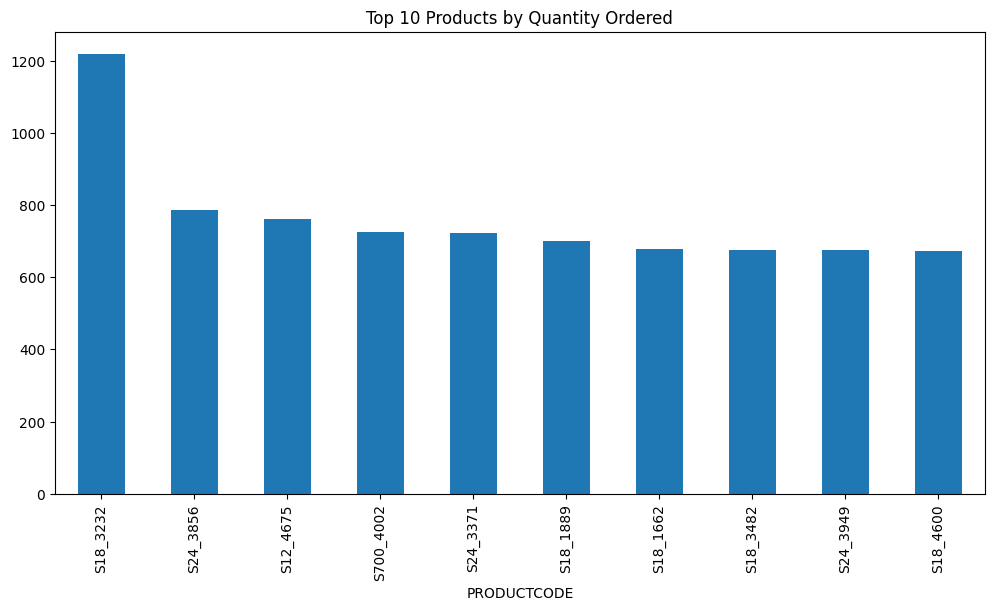

In [13]:
stock_movement = data.groupby('PRODUCTCODE')['QUANTITYORDERED'].sum()
plt.figure(figsize=(12, 6))
stock_movement.nlargest(10).plot(kind='bar', title='Top 10 Products by Quantity Ordered')
plt.savefig('stock_movement.png')
plt.show()

##### 4. Seasonality Analysis

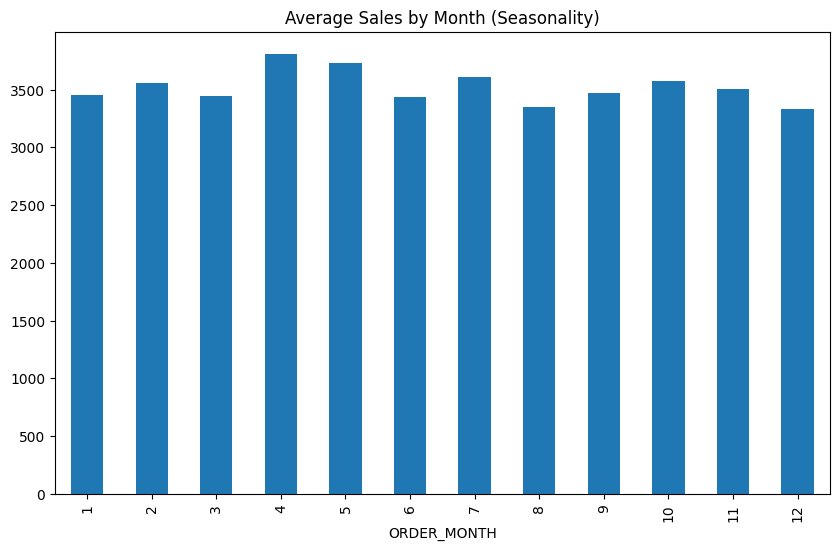

In [14]:
monthly_avg = data.groupby('ORDER_MONTH')['SALES'].mean()
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='bar', title='Average Sales by Month (Seasonality)')
plt.savefig('seasonality.png')
plt.show()

##### 5. Churn/Repeat Purchase Analysis

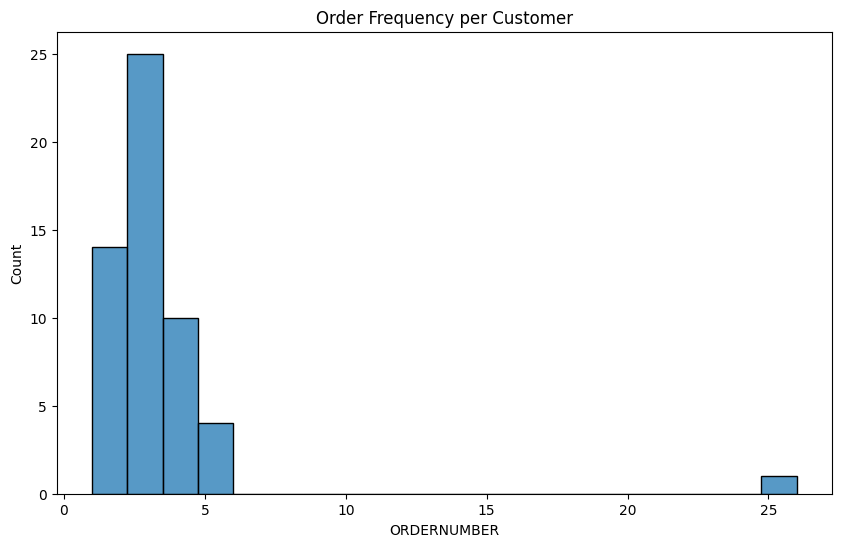

Repeat Customers (more than 1 order): 53


In [15]:
repeat_customers = data.groupby('CUSTOMERNAME')['ORDERNUMBER'].nunique()
plt.figure(figsize=(10, 6))
sns.histplot(repeat_customers, bins=20)
plt.title('Order Frequency per Customer')
plt.savefig('repeat_customers.png')
plt.show()
print(f"Repeat Customers (more than 1 order): {(repeat_customers > 1).sum()}")

##### 6. Market Basket Analysis

In [16]:
order_baskets = data.groupby('ORDERNUMBER')['PRODUCTCODE'].apply(list)
product_pairs = order_baskets.apply(lambda x: list(combinations(x, 2)))
pair_counts = pd.Series([pair for sublist in product_pairs for pair in sublist]).value_counts()
print("Top 5 Product Pairs:\n", pair_counts.head())

Top 5 Product Pairs:
 (S24_3856, S18_1889)    12
(S24_4048, S24_1444)    12
(S12_4675, S18_1889)    12
(S12_3990, S12_3380)    12
(S18_4522, S18_3259)    11
Name: count, dtype: int64


##### 7. Geospatial Analysis

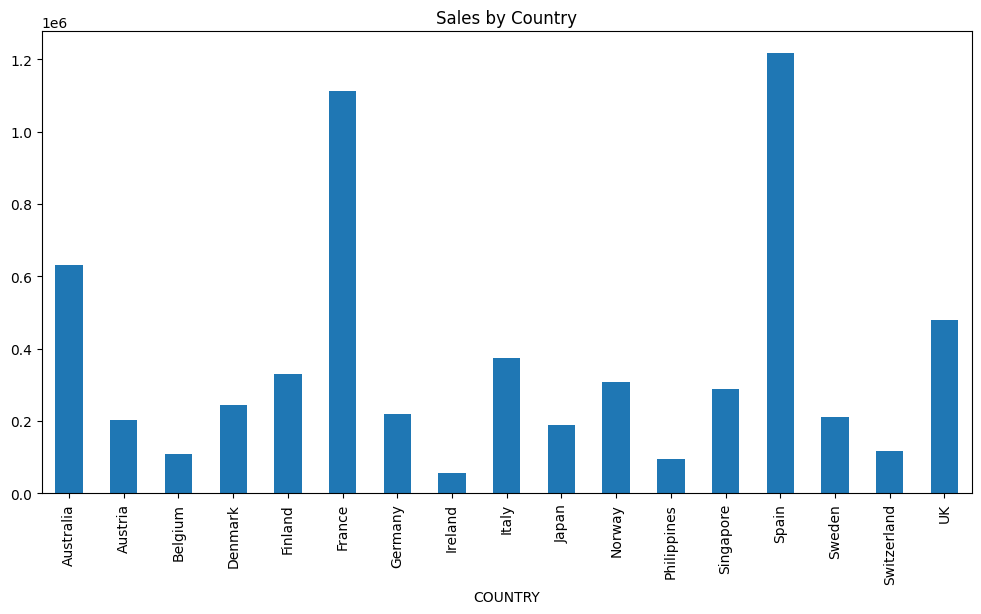

In [17]:
country_sales = data.groupby('COUNTRY')['SALES'].sum()
plt.figure(figsize=(12, 6))
country_sales.plot(kind='bar', title='Sales by Country')
plt.savefig('sales_by_country.png')
plt.show()

#### Step 6: Time Series Analysis

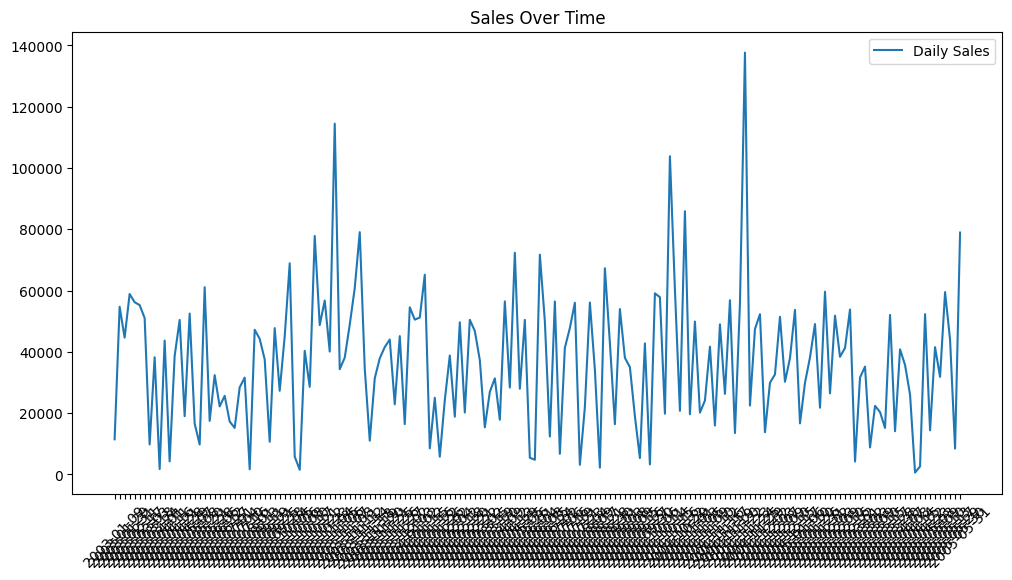

In [19]:
daily_sales = data.groupby('ORDERDATE')['SALES'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ORDERDATE'], daily_sales['SALES'], label='Daily Sales')
plt.title('Sales Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.savefig('daily_sales_time_series.png')
plt.show()

#### Step 7: Machine Learning with Pipeline
##### Prepare Data

In [20]:
X = data[['QUANTITYORDERED', 'PRICEEACH', 'SALES_LAG1', 'SALES_ROLLING_7D', 'PRODUCTLINE_ENCODED', 'DEALSIZE_ENCODED']]
y = data['SALES']
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

##### Pipeline

In [21]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"Pipeline - MSE: {mean_squared_error(y_test, y_pred):.2f}, R2: {r2_score(y_test, y_pred):.2f}")

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(pipeline, X, y, cv=tscv, scoring='r2')
print(f"CV R2 Scores: {cv_scores}, Avg: {cv_scores.mean():.2f}")

Pipeline - MSE: 397109.52, R2: 0.91
CV R2 Scores: [0.92471146 0.91394941 0.90972602 0.89944001 0.90765392], Avg: 0.91


##### Prediction Visualization

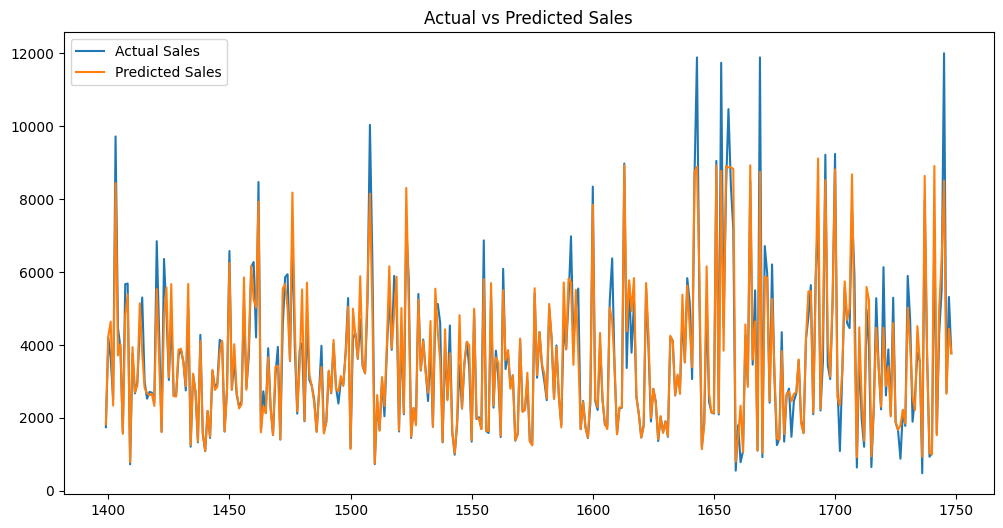

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.savefig('actual_vs_predicted_sales.png')
plt.show()

### Step 8: Business Recommendations
### Based on the analysis, here are tailored recommendations for the client:

#### 1) Customer Strategy:
##### Focus on High Segment customers (top 10 by sales). Offer loyalty discounts to retain them.
##### Target Medium Segment with upselling campaigns based on frequent product pairs (from market basket).
#### 2) Profit Optimization:
##### Prioritize high-profit product lines (e.g., check profit_by_product). Reduce focus on low-margin lines unless they drive volume.
#### 3) Inventory Management:
##### Stock up on top 10 products by quantity ordered ahead of peak seasons (e.g., high-sales months from seasonality).
#### 4) Seasonal Planning:
##### Increase marketing and inventory in peak months (e.g., from seasonality.png). Offer promotions in low months to boost sales.
#### 5) Geographic Expansion:
##### Invest in high-sales countries (from sales_by_country.png). Explore untapped markets with similar traits.
#### 6) Cross-Selling:
##### Bundle products from top product pairs (market basket) in promotions or displays.
#### 7) Forecasting:
##### Use the Random Forest model to predict sales and adjust inventory/staffing accordingly.